# Detrended Fluctuation Analysis (DFA) Module

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Convert to mean-centered cumulative sum (MCS)

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_9864\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


<AxesSubplot:xlabel='Time'>

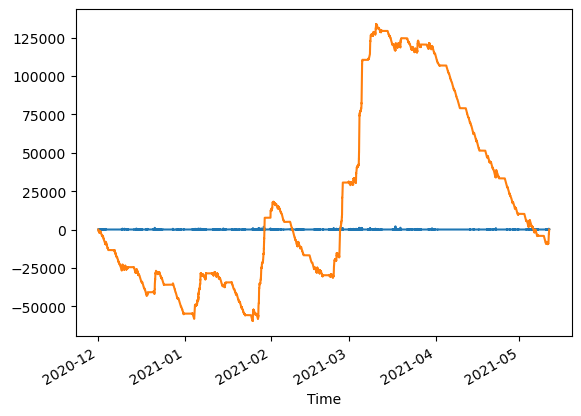

In [3]:
n_sample = 60 * 24 * 100

mcs = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
mcs['mean'] = [mcs['log_ret_sq'].mean()] * n_sample
mcs['mean_centered'] = mcs['log_ret_sq'] - mcs['mean']
mcs['mean_centered_cum_sum'] = mcs['mean_centered']
mcs['mean_centered_cum_sum'] = mcs['mean_centered_cum_sum'].cumsum()

mcs['log_ret_sq'].plot()
mcs['mean_centered_cum_sum'].plot()

In [4]:
mcs

,log_ret_sq,mean,mean_centered,mean_centered_cum_sum
Time,,,,
2020-12-01 00:01:00,3.733753,6.480652,-2.746899,-2.746899e+00
2020-12-01 00:02:00,0.634167,6.480652,-5.846485,-8.593384e+00
2020-12-01 00:03:00,1.144941,6.480652,-5.335711,-1.392909e+01
2020-12-01 00:04:00,0.074901,6.480652,-6.405751,-2.033485e+01
2020-12-01 00:05:00,2.233315,6.480652,-4.247337,-2.458218e+01
...,...,...,...,...
2021-05-11 15:56:00,105.736477,6.480652,99.255825,-7.985719e+01
2021-05-11 15:57:00,0.359840,6.480652,-6.120812,-8.597800e+01
2021-05-11 15:58:00,2.746562,6.480652,-3.734090,-8.971209e+01


## 2. Define log-spaced 'scales'

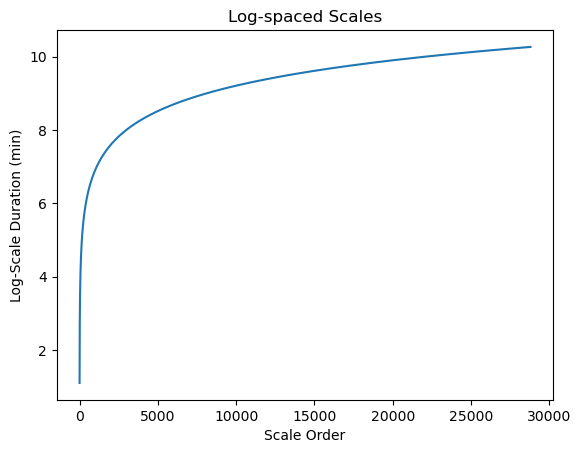

In [5]:
scales_max = int(n_sample / 5)
scales = np.array([i for i in range(3, scales_max+1)])
n_epochs = np.divide(n_sample, scales).astype(int)
n_scales = len(scales)
log_scales = np.log(scales)

plt.plot(range(1, n_scales+1), log_scales)
plt.xlabel('Scale Order')
plt.ylabel('Log-Scale Duration (min)')
plt.title('Log-spaced Scales')

plt.show()

## 3. Split sample into epochs, detrend, compute RMS

In [6]:
# Define dataframe index
scale_list_forward = ['s_fd_' + str(i) for i in scales]
scale_list_backward = ['s_bd_' + str(i) for i in range(scales_max, 3-1, -1)]
scale_list = scale_list_forward + scale_list_backward
scale_list

# Initiate dataframe
dfa = pd.DataFrame(index=scale_list)

dfa['epoch_size'] = np.concatenate((n_epochs, n_epochs[::-1]), axis=None)
dfa

,epoch_size
s_fd_3,48000
s_fd_4,36000
s_fd_5,28800
s_fd_6,24000
s_fd_7,20571
...,...
s_bd_7,20571
s_bd_6,24000
s_bd_5,28800
s_bd_4,36000


In [7]:
# Analysize each epoch
for j in dfa['epoch_size'][:1]:
    a = pd.DataFrame(np.resize(mcs['mean_centered_cum_sum'][:j*int(n_sample/j)], (j, int(n_sample/j))).T)
            
    print(a)

       0          1          2          3          4          5      \
0  -2.746899 -20.334846 -36.831908 -52.258820 -66.440797 -81.942178   
1  -8.593384 -24.582182 -41.461622 -57.996185 -69.253890 -88.105249   
2 -13.929095 -30.642013 -46.068924 -64.027263 -75.461526 -94.492027   

        6           7           8           9      ...       47990  \
0  -99.775406 -118.366631 -135.177826 -153.905249  ... -952.499275   
1 -106.255788 -124.529789 -140.944215 -158.470157  ... -950.443057   
2 -112.642581 -128.714408 -147.424867 -164.651458  ... -926.394860   

        47991       47992       47993       47994       47995       47996  \
0 -904.846785 -633.724844 -579.404135 -439.288293 -372.704074 -334.148025   
1 -907.570141 -634.412289 -569.915111 -431.476811 -374.477489 -339.142388   
2 -784.996720 -614.032211 -485.660919 -425.679383 -372.630913 -299.659709   

        47997       47998         47999  
0 -222.098443 -179.113014 -8.971209e+01  
1 -222.805435  -79.857190 -9.619253e+01  